## Inference Guidance

Install LLaVA repo with code and environments: pip install git+https://github.com/LLaVA-VL/LLaVA-NeXT.git

You will need to install `flash-attn` to use this code snippet. If you don't want to install it, you can set `attn_implementation=None` when load_pretrained_model

In [1]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

import sys
import warnings

warnings.filterwarnings("ignore")
pretrained = "lmms-lab/llava-onevision-qwen2-0.5b-si"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"

tokenizer, model, image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map)  # Add any other thing you want to pass in llava_model_args
model.eval()

/home2/s20235561/.conda/envs/evlm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home2/s20235561/.conda/envs/evlm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loaded LLaVA model: lmms-lab/llava-onevision-qwen2-0.5b-si


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_qwen. This is not supported for all configurations of models and can yield errors.


Loading vision tower: google/siglip-so400m-patch14-384
Model Class: LlavaQwenForCausalLM


LlavaQwenForCausalLM(
  (model): LlavaQwenModel(
    (embed_tokens): Embedding(151647, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2FlashAttention2(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
    (vision_tower): Sig

In [31]:
import os
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def model_inference(model, samples_path, questions, image_processor=image_processor, tokenizer=tokenizer, modality="image", conv_template = None, max_new_tokens = 4096, skip_special_tokens = True, frames_num=None):
    
    assert modality == "image", "Invalid modality."
        
    # if the path is a single image, convert it to a list
    if os.path.isfile(samples_path):
        samples = [samples_path]
    elif isinstance(samples_path, list):
        samples = samples_path
    else:
        # extract samples from the path
        samples = os.listdir(samples_path)
        samples = [os.path.join(samples_path, sample) for sample in samples]
    
    assert len(questions) == 1 or len(questions) == len(samples_path), "Number of questions should be equal to the number of samples or 1."

    responses = []
    for idx, sample in enumerate(samples):
        image = Image.open(sample)
        image_tensors = process_images([image], image_processor, model.config)
        image_tensors= [_image.to(dtype=torch.float16, device=device) for _image in image_tensors]
        image_sizes = [image.size]
        # print("Image tensor size: ", image_tensors[0].size())

        
        # Prepare conversation input
        conv_template = "qwen_1_5" if conv_template is None else conv_template
        conv = copy.deepcopy(conv_templates[conv_template])

        if len(questions) == 1:
            conv.append_message(conv.roles[0], questions[0])
            question = questions[0]
        else:
            conv.append_message(conv.roles[0], questions[idx])
            question = questions[idx]

        conv.append_message(conv.roles[1], None)
        prompt_question = conv.get_prompt()
        
        input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)

        # Generate response
                
        cont = model.generate(
            input_ids,
            images=image_tensors,
            image_sizes=image_sizes,
            do_sample=False,
            temperature=0.2,
            max_new_tokens=max_new_tokens,
            modalities=[modality],
        )
        text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=skip_special_tokens)
        response = text_outputs[0]
            
        plt.imshow(image)
        plt.axis('off')  # Optional, to hide the axis
        plt.show()
        
        # print("Image: ", sample)
        
        print("Question: ", question)
        print("-"*50)
        print("Response:")
        # Define your text with HTML for font size
        text = f"""
        <span style="font-size: 18px;">
            {response}
        </span>
        """
        # Display the text
        display(HTML(text))
        print("-"*50)

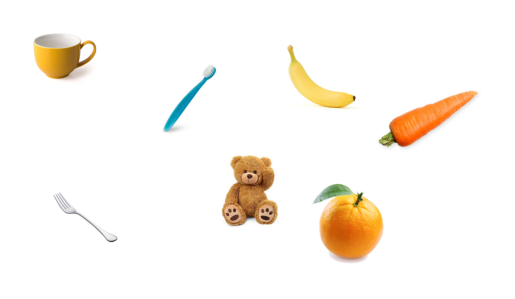

Question:  <image>
What shown in this image? Give each object's bounding box coordinates.
--------------------------------------------------
Response:


--------------------------------------------------


In [ ]:
image_path  = "images/image2.png"
question = DEFAULT_IMAGE_TOKEN + "\nWhat shown in this image? Give each object's bounding box coordinates."
model_inference(model, image_path, [question], modality="image", max_new_tokens=4096, skip_special_tokens=True)

In [ ]:
from utils.visualize import visualize_bbox

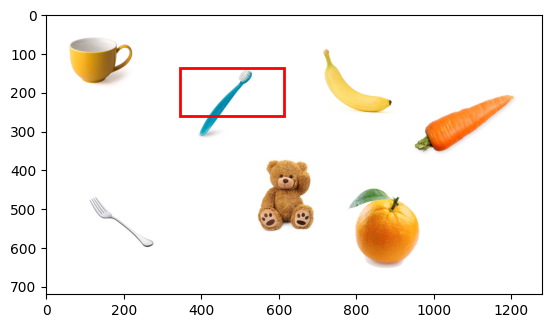

In [ ]:
image_path = "images/image2.png"
# These should be in the format [x_min, y_min, x_max, y_max]
bbox =   [0.27, 0.19, 0.48, 0.36] # toothbrush
visualize_bbox(image_path, bbox)

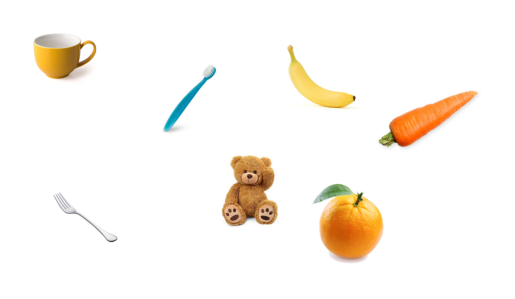

Question:  <image>
Give the bounding box coordinates of the teddy bear.
--------------------------------------------------
Response:


--------------------------------------------------


In [ ]:
image_path  = "images/image2.png"
question = DEFAULT_IMAGE_TOKEN + "\nGive the bounding box coordinates of the teddy bear."
model_inference(model, image_path, [question], modality="image", max_new_tokens=4096, skip_special_tokens=True)

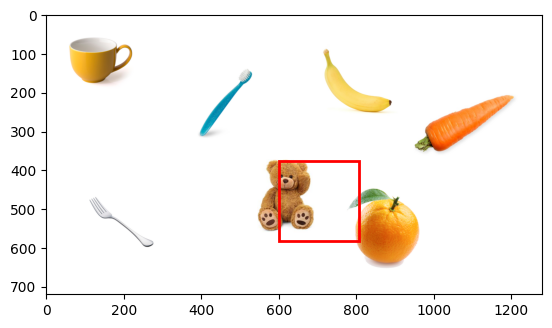

In [ ]:
bbox = [0.47, 0.52, 0.63, 0.81] # teddy bear
visualize_bbox(image_path, bbox)

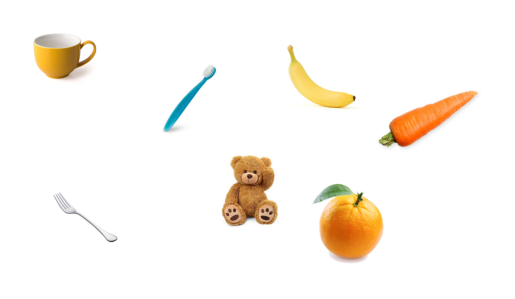

Question:  <image>
Give the bounding box coordinates of the banana.
--------------------------------------------------
Response:


--------------------------------------------------


In [ ]:
image_path  = "images/image2.png"
question = DEFAULT_IMAGE_TOKEN + "\nGive the bounding box coordinates of the banana."
model_inference(model, image_path, [question], modality="image", max_new_tokens=4096, skip_special_tokens=True)

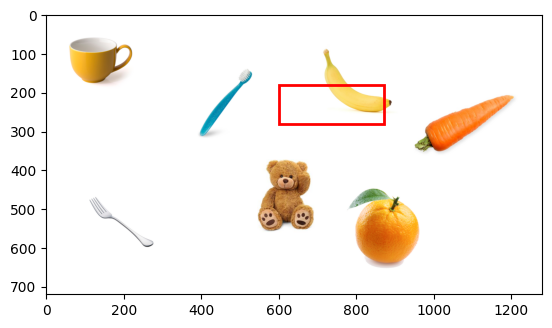

In [ ]:
bbox = [0.47, 0.25, 0.68, 0.39] # banana
visualize_bbox(image_path, bbox)